***




<h1><center>Sử dụng thuật toán để phân loại cho bài toán "Phân loại Giá điện thoại"</center></h1>

### Nội dung bài làm

1. Bài toán và Thuật toán sử dụng
2. Thông tin dữ liệu
3. Khám phá dữ liệu - Exploratory Data Analysis
4. Tiền xử lý dữ liệu và 
5. Xây dựng Mô hình Phân loại
6. Đưa ra kết luận và giải quyết bài toán


***
### 0. Thiết lập SparkSession

In [2]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkML').getOrCreate()
spark

***
### 1. Mục tiêu bài toán và Hướng giải quyết

   **Mục tiêu bài toán**
- Phân loại phạm vi giá của điện thoại di động cho dữ liệu thử nghiệm <font color=green>test.csv</font>

**Hướng giải quyết**
- Từ bộ dữ liệu có nhãn <font color=green>train.csv</font> tiến hành phân tích khám phá tổng thể dữ liệu.
- Tiến hành sử dụng các `Thuật toán phân loại` để xây dựng mô hình từ đó tìm ra được Thuật toán có chính xác cao nhất. Sử dụng thuật toán đó để giải quyết mục tiêu bài toán bài toán.

**Các thuật toán Phân loại**
- `Naive Bayes`
- `Decision tree classifier`
- `Random forest classifier`
- `Logistic regression`
- `Multilayer perceptron classifier`

***
### 2. Thông tin dữ liệu

Chúng ta có thể thấy rằng:

- File <font color=green>train.csv</font> có  2000 dòng, 21 cột.
- File <font color=green>test.csv</font> có  1000 dòng, 20 cột.
- Cả 2 file đều là dữ liệu có giá trị số nguyên.

File <font color=green>train.csv</font> và <font color=green>test.csv</font> có tập hợp các cột với tên gần như nhau, ngoại trừ cột `Price_range` không xuất hiện ở file <font color=green>test.csv</font>.

Bài toán đặt ra là dùng các cột còn lại của file <font color=green>train.csv</font> để huấn luyện một mô hình sao cho nó có thể dựa đoán được cột `Price_range` này dựa trên những cột của file <font color=green>test.csv</font>.

**Ý nghĩa của từng trường dữ liệu**

1. <font color=blue>Battery_power:</font> Tổng năng lượng mà pin có thể lưu trữ trong một lần được tính bằng mAh
2. <font color=blue>Blue:</font>             Có bluetooth hay không?
    - `1 là có bluetooth`
    - `2 là không có bluetooth`
3. <font color=blue>Clock_speed:</font> Tốc độ bộ vi xử lý thực hiện các lệnh
4. <font color=blue>Dual_sim:</font> Có hỗ trợ sim kép hay không
    - `1 là có hỗ trợ sim kép`
    - `2 là không có hỗ trợ sim kép`
5. <font color=blue>fc:</font> Trước mega pixel
6. <font color=blue>Four_g:</font> Có 4G hay không
    - `1 là có 4G`
    - `2 là không có 4G`
7. <font color=blue>int_memory:</font> Bộ nhớ trong tính bằng Gigabyte
8. <font color=blue>m_dep:</font> Độ sâu Di động tính bằng cm
9. <font color=blue>mobile_wt:</font> Trọng lượng của điện thoại di động
10. <font color=blue>n_cores:</font> Số lõi của bộ xử lý
11. <font color=blue>pc:</font> Camera chính mega pixel
12. <font color=blue>px_height:</font> Chiều cao độ phân giải pixel
13. <font color=blue>px_width:</font> Chiều rộng độ phân giải pixel
14. <font color=blue>ram:</font> Bộ nhớ truy cập ngẫu nhiên trong Mega Byte
15. <font color=blue>sc_h:</font> Chiều cao màn hình của thiết bị di động tính bằng cm
16. <font color=blue>sc_w:</font> Chiều rộng màn hình của thiết bị di động tính bằng cm
17. <font color=blue>talk_time:</font> thời gian dài nhất mà một lần sạc pin sẽ kéo dài bao lâu
18. <font color=blue>Three_g:</font> Có 3G hay không
19. <font color=blue>touch_screen:</font> Có màn hình cảm ứng hay không?
    - `1 là có màn hình cảm ứng`
    - `2 là không có màn hình cảm ứng`
20. <font color=blue>wifi:</font> Có wifi hay không?
    - `1 là có wifi`
    - `2 là không có wifi`
21. <font color=blue>price_range:</font> Đây là biến mục tiêu có giá trị 
    -  `0 (chi phí thấp)`
    -  `1 (chi phí trung bình)`
    -  `2 (chi phí cao)`
    -  `3 (chi phí rất cao)`

In [ ]:
# Dữ liệu Huấn luyện mô hình
train_df = spark.read.csv('Mobile_train.csv', header = True, inferSchema = True)
train_df.show(3)
# Dữ liệu cần được giải quyết
test_df = spark.read.csv('Mobile_test.csv', header = True, inferSchema = True)
test_df.show(3)

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|         1954|   0|        0.5|       1|  0|     0|        24|  0.8|      187|      4|  0|      512|    1149| 700|  16|   3|        5|      1|           1|   1|          0|
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|     

In [ ]:
# Xóa cột id trong test_df 
test_df = test_df.drop('id')

In [ ]:
# Kích thước dữ liệu và Schema
print(f"kích thước của dữ liệu train_df: {train_df.count()} dòng, {len(train_df.columns)} cột")

train_df.printSchema()

 kích thước của dữ liệu train_df: 2000 dòng, 21 cột
root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)
 |-- price_range: integer (nullable = true)



In [ ]:
print(" kích thước của dữ liệu test_df: {} dòng, {} cột".format(test_df.count(), len(test_df.columns)))
test_df.printSchema()

 kích thước của dữ liệu test_df: 1000 dòng, 20 cột
root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)



**Kiểm tra dữ liệu khuyết**
- Nhìn qua 2 bảng được thống kê có thể thấy `không có giá trị nào bị khuyết.`

In [ ]:
# train_df
from pyspark.sql.functions import isnan, when, count, col
train_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()
# test.csv
test_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+---+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width|ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+---+----+----+---------+-------+------------+----+-----------+
|            0|   0|          0|       0|  0|     0|         0|    0|        0|      0|  0|        0|       0|  0|   0|   0|        0|      0|           0|   0|          0|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+---+----+----+---------+-------+------------+----+-----------+

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+---+----+----+---------+

**Giá trị thống kê**

In [ ]:
train_df.describe().toPandas()

,summary,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,count,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
1,mean,1238.5185,0.495,1.5222499999999983,0.5095,4.3095,0.5215,32.0465,0.5017500000000017,140.249,...,645.108,1251.5155,2124.213,12.3065,5.767,11.011,0.7615,0.503,0.507,1.5
2,stddev,439.4182060835313,0.5001000400170073,0.816004208895068,0.5000347661750049,4.341443747983898,0.49966246736236364,18.145714955206856,0.2884155496235117,35.39965489638834,...,443.78081080643824,432.1994469463379,1084.7320436099492,4.213245004356303,4.356397605826408,5.463955197766688,0.426272922318731,0.5001160445626741,0.5000760322381088,1.1183136021064597
3,min,501,0,0.5,0,0,0,2,0.1,80,...,0,500,256,5,0,2,0,0,0,0
4,max,1998,1,3.0,1,19,1,64,1.0,200,...,1960,1998,3998,19,18,20,1,1,1,3


***
###  3. Khám phá dữ liệu - Exploratory Data Analysis

Phân tích dữ liệu khám phá là gì?

- Phân tích dữ liệu khám phá hoặc EDA được sử dụng để thu thập thông tin chi tiết từ dữ liệu. Các nhà khoa học và phân tích dữ liệu cố gắng tìm ra các mẫu, mối quan hệ và sự bất thường khác nhau trong dữ liệu bằng cách sử dụng một số biểu đồ thống kê và các kỹ thuật trực quan khác.

Những phần của EDA:

- Nhận thông tin chi tiết tối đa từ tập dữ liệu
- Khám phá cấu trúc cơ bản
- Trích xuất các biến quan trọng từ tập dữ liệu
- Phát hiện những điểm bất thường và bất thường (nếu có)
- Kiểm tra các giả định cơ bản
- Xác định cài đặt hệ số tối ưu

Tại sao EDA lại quan trọng?

- Mục đích chính của EDA là phát hiện bất kỳ lỗi nào, ngoại lệ cũng như để hiểu các mẫu khác nhau trong dữ liệu. Nó cho phép Nhà phân tích hiểu dữ liệu tốt hơn trước khi đưa ra bất kỳ giả định nào. Kết quả của EDA giúp các doanh nghiệp biết khách hàng của họ, mở rộng kinh doanh và đưa ra quyết định phù hợp.

**Thư viện trực quan hóa dữ liệu**

In [ ]:
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sweetviz as sv

**Hệ số tương quan**
- Hệ số tương quan nằm trong khoảng từ –1 đến 1. 
- Khi nó gần bằng 1, có nghĩa là có mối tương quan thuận mạnh; ví dụ: giá trị trung bình có xu hướng tăng lên khi số lượng phòng tăng lên. 
- Khi hệ số gần với –1, điều đó có nghĩa là có mối tương quan âm mạnh; giá trị trung vị có xu hướng giảm xuống khi tỷ lệ phần trăm dân số có địa vị thấp hơn tăng lên. 
- Cuối cùng, các hệ số gần bằng 0 có nghĩa là không có tương quan tuyến tính.

**Hệ số tương quan giữa các biến**

Thông qua Hệ số tương quan giữa `price_range` và các biến khác có thể thấy:

Các biến có hệ tương quan cao nhất là:
- `Ram`: <font color=green>91.7%</font>
- `Battery_power`: <font color=green>20%</font>
- `px_width`: <font color=green>16,5%</font> và `px_height`: <font color=green>14.88%</font>

Hệ số tương quan thấp nhất là:
- `n_cores`:      <font color=red>0.4399%</font>        
- `m_dep`:        <font color=red>0.0853%</font>
- `clock_speed`:  <font color=red>-0.6606%</font>
- `mobile_wt`:    <font color=red>-3.0302</font>
- `touch_screen`: <font color=red>-3.0304</font>

Nhìn qua hệ số tương quan có thể thấy trừ 4 biến `Ram`,`Battery_power`,`px_width` và `px_height` thì các biến khác khồn vượt quá 5% thể hiện nhưng biến này có mối tương quan rất nhỏ với `price_range`.

Đặc biệt có 3 biến `clock_speed`,`mobile_wt` và `touch_screen` có <font color=red>hệ số tương quan âm</font>thể hiện nhưng biến này hoàn toàn không có quan hệ với `price_range`.

In [ ]:
df = train_df.toPandas() # chuyển dữ liệu sang Pandas để vẽ biểu đồ
corrmat = df.corr() # hàm corr tính hệ số tương quan
corrmat.sort_values(by=["price_range"], ascending=False).iloc[0].sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

Text(0.5, 1.0, 'Biểu đồ Hệ tương quan giữa các biến')

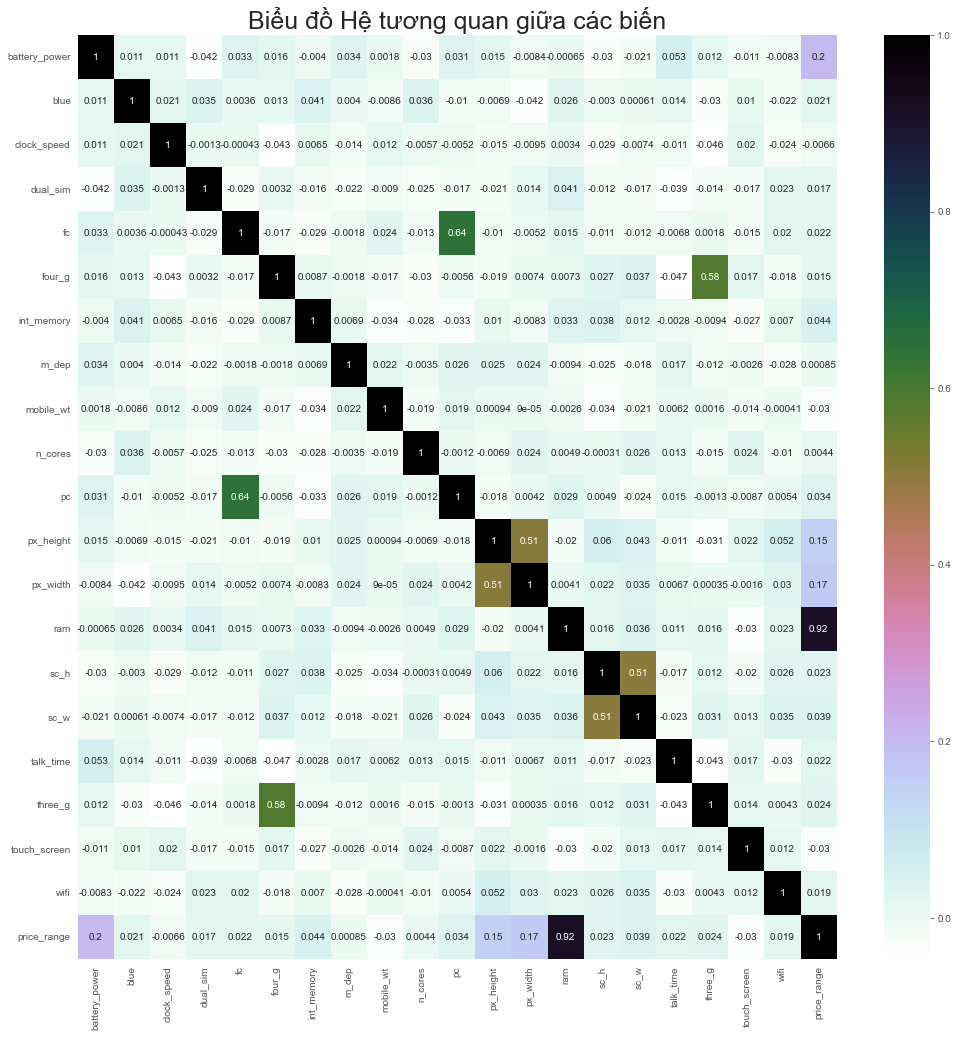

In [ ]:
plt.figure(figsize = (17,17)) # kích thước biểu đồ
sns.heatmap(corrmat,  cmap="cubehelix_r", annot = True)
plt.title('Biểu đồ Hệ tương quan giữa các biến', fontsize = 25)

In [ ]:
# Gán lần lượt các giá trị số {0,1,2,3} với các tên tương ứng.
range_mapping = {0: "Chi phí thấp",
                 1: "Chi phi trung bình",
                 2: "Chi phí cao",
                 3: "Chi phí rất Cao"}

In [ ]:
# Map: giống như 1 vòng lặp
df['price_range_mapped'] = df['price_range'].map(range_mapping) 
# dùng map gán dữ liệu dựa theo range_mapping 

**Phân phối Giá điện thoại**
- Có thể thấy phân phối của giá điện thoại có sự tương đồng nhau

Phân phối của Phân khúc giá: 
Chi phí thấp          500
Chi phi trung bình    500
Chi phí cao           500
Chi phí rất Cao       500
Name: price_range_mapped, dtype: int64


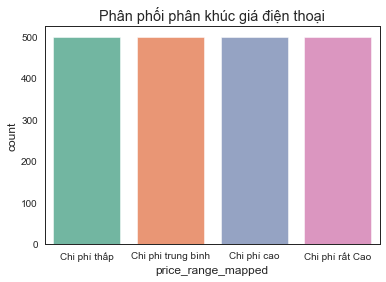

In [ ]:
print(f"Phân phối của Phân khúc giá: \n{df['price_range_mapped'].value_counts()}")
sns.countplot(x = "price_range_mapped", data = df, palette="Set2").set(title='Phân phối phân khúc giá điện thoại')
plt.show()

**Phân phối của Ram theo giá**
- Tát cả phân phối của ram theo giá đề có số tương đương là 500.

`Chi phí thấp:` 
- Thiết bị có `ram` thấp nhất là `256` mb và đạt giá trị lớn nhất `1974` mb
- Cho thấy các sản phẩm ở phân khúc chi phí thấp sẽ có trung bình (Mean) ram bằng `785` mb
- Giá trị Median (50%) : `719,5` cho thấy ở phân khúc này có hơn 50% điện thoại sẽ có ram lớp hơn mức Median và `Mean > Median` làm cho biểu đồ phân phối bị lệch phải.

In [ ]:
ram_0 = df.loc[df['price_range'] == 0, ['ram']]
print("Bảng thống kê Ram ở Chi phí thấp \n{}".format(ram_0.describe())) 

Bảng thống kê Ram ở Chi phí thấp 
               ram
count   500.000000
mean    785.314000
std     362.755397
min     256.000000
25%     488.750000
50%     719.500000
75%    1037.000000
max    1974.000000


`Chi phí Trung bình:` 
- Thiết bị có `ram` thấp nhất là `387` mb và đạt giá trị lớn nhất `2811` mb
- Cho thấy các sản phẩm ở phân khúc chi phí Trung bình sẽ có trung bình (Mean) ram bằng `1679` mb
- Giá trị Median (50%) : `1686` cho thấy ở phân khúc này có hơn 50% điện thoại sẽ có ram lớp hơn mức `1686` và `Mean nhỏ hơn Median` nhưng không quá lớn điều này cho thấy biểu đồ phân phối có sự `Đối xứng`

In [ ]:
ram_1 = df.loc[df['price_range'] == 1, ['ram']]
print("Bảng thống kê Ram ở Chi phí Trung bình: \n{}".format(ram_1.describe()))

Bảng thống kê Ram ở Chi phí Trung bình: 
               ram
count   500.000000
mean   1679.490000
std     465.850159
min     387.000000
25%    1354.000000
50%    1686.500000
75%    2033.750000
max    2811.000000


`Chi phí Cao:` 

- Thiết bị có `ram` thấp nhất là `1185` mb và đạt giá trị lớn nhất `3916` mb
- Cho thấy các sản phẩm ở phân khúc chi phí Cao sẽ có trung bình (Mean) ram bằng `2582` mb
- Giá trị Median (50%) : `2577` cho thấy ở phân khúc này có hơn 50% điện thoại sẽ có ram lớp hơn mức `2577` và `Mean nhỏ hơn Median` nhưng không quá lớn điều này cho thấy biểu đồ phân phối có sự `Đối xứng`.

In [ ]:
ram_2 = df.loc[df['price_range'] == 2, ['ram']]
print("Bảng thống kê Ram ở Chi phí Cao: \n{}".format(ram_2.describe()))

Bảng thống kê Ram ở Chi phí Cao: 
               ram
count   500.000000
mean   2582.816000
std     496.211735
min    1185.000000
25%    2292.750000
50%    2577.000000
75%    2927.000000
max    3916.000000


`Chi phí rất Cao:` 

- Thiết bị có `ram` thấp nhất là `2259` mb và đạt giá trị lớn nhất `3998` mb
- Cho thấy các sản phẩm ở phân khúc chi phí rất Cao sẽ có trung bình (Mean) ram bằng `3449.2` mb
- Giá trị Median (50%) : `3509.5` cho thấy ở phân khúc này có hơn 50% điện thoại sẽ có ram lớp hơn mức `3509.5` và `Mean < Median` điều này cho thấy biểu đồ phân phối của bị lệch Trái.

In [ ]:
ram_3 = df.loc[df['price_range'] == 3, ['ram']]
print("Bảng thống kê Ram ở Chi phí rất cao: \n{}".format(ram_3.describe()))

Bảng thống kê Ram ở Chi phí rất cao: 
               ram
count   500.000000
mean   3449.232000
std     393.019923
min    2259.000000
25%    3207.500000
50%    3509.500000
75%    3764.750000
max    3998.000000


**Biểu đồ Phân phối của Ram**

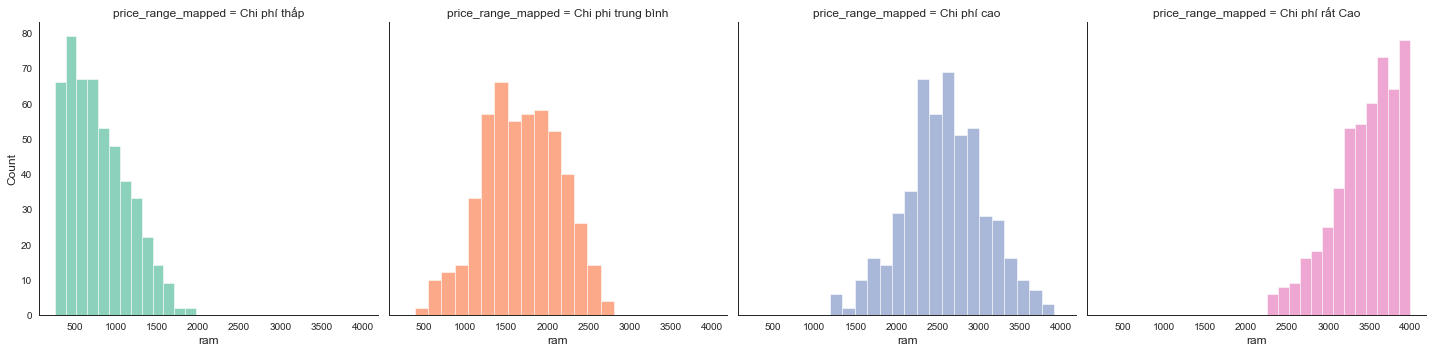

In [ ]:
grid = sns.FacetGrid(df, col="price_range_mapped", hue="price_range_mapped", palette="Set2", height=5)
grid.map(sns.histplot, "ram")
plt.show()

**Bluetooth**
- Số lượng thiết bị Không hỗ trợ Bluetooth là `1010` lớn hơn những thiết bị có hỗ trợ là `990`

Phân phối của Bluetooth: 
Không hỗ trợ    1010
Có hỗ trợ        990
Name: blue_mapped, dtype: int64


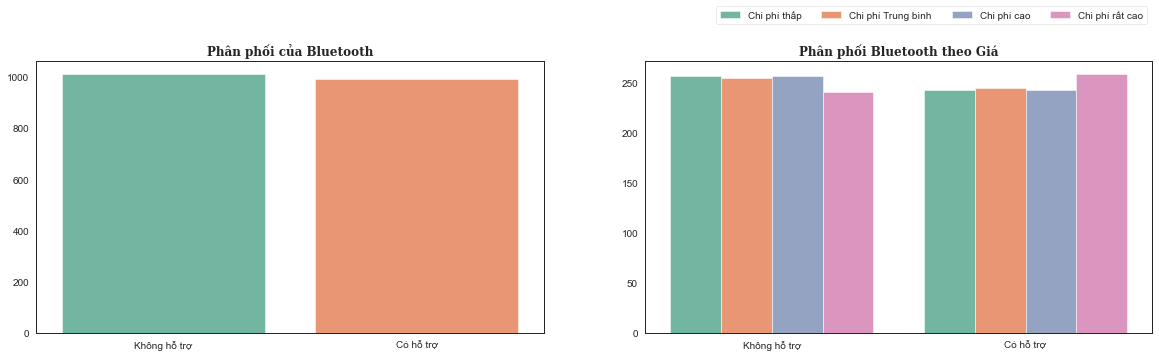

In [ ]:
b_mapping = {0: "Không hỗ trợ",
                1: "Có hỗ trợ",}
df['blue_mapped'] = df['blue'].map(b_mapping) 
print("Phân phối của Bluetooth: \n{}".format(df['blue_mapped'].value_counts()))

fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

sns.countplot(x='blue_mapped', data = df, palette="Set2", ax=ax0)
ax0.set_title('Phân phối của Bluetooth',fontsize=12,fontfamily='serif',fontweight='bold')
ax0.set_xlabel("")
ax0.set_ylabel("")

sns.countplot(x='blue_mapped', data = df, palette="Set2", hue='price_range_mapped', ax=ax1)
ax1.set_title('Phân phối Bluetooth theo Giá',fontsize=12,fontfamily='serif',fontweight='bold')
legend_labels, _= ax1.get_legend_handles_labels()
ax1.legend(legend_labels, ['Chi phí thấp', 'Chi phí Trung bình','Chi phí cao','Chi phí rất cao'], ncol=4, bbox_to_anchor=(1, 1.22))
ax1.set_xlabel("")
ax1.set_ylabel("")

plt.show()

**Battery Power**

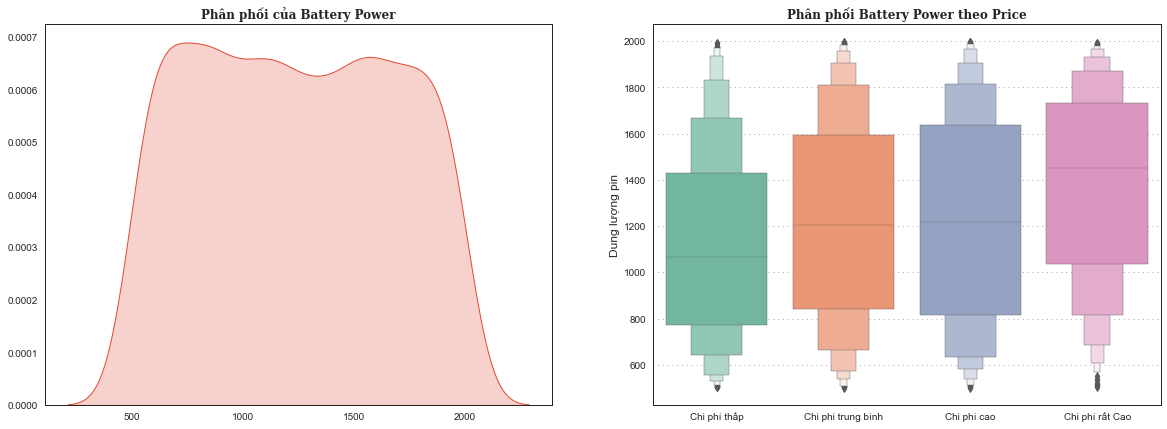

In [ ]:
fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

sns.kdeplot(x='battery_power', data=df, shade=True, linewidth = 1, ax=ax0)
ax0.set_title('Phân phối của Battery Power',fontsize=12,fontfamily='serif',fontweight='bold')
ax0.set_xlabel("")
ax0.set_ylabel("")

ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(x='price_range_mapped', y='battery_power', data=df, palette="Set2", ax=ax1,
              linewidth=0.4).set_title('Phân phối của Battery Power theo Price',fontsize=12,fontfamily='serif',fontweight='bold')
ax1.set_title('Phân phối Battery Power theo Price',fontsize=12,fontfamily='serif',fontweight='bold')
ax1.set_xlabel("")
ax1.set_ylabel("Dung lượng pin")

plt.show()

**Hỗ trợ 4G**

Phân phối của 4G: 
Có hỗ trợ       1043
Không hỗ trợ     957
Name: 4G_mapped, dtype: int64
Phân phối của Dual sim: 
Có hỗ trợ       1019
Không hỗ trợ     981
Name: Dual_sim_mapped, dtype: int64


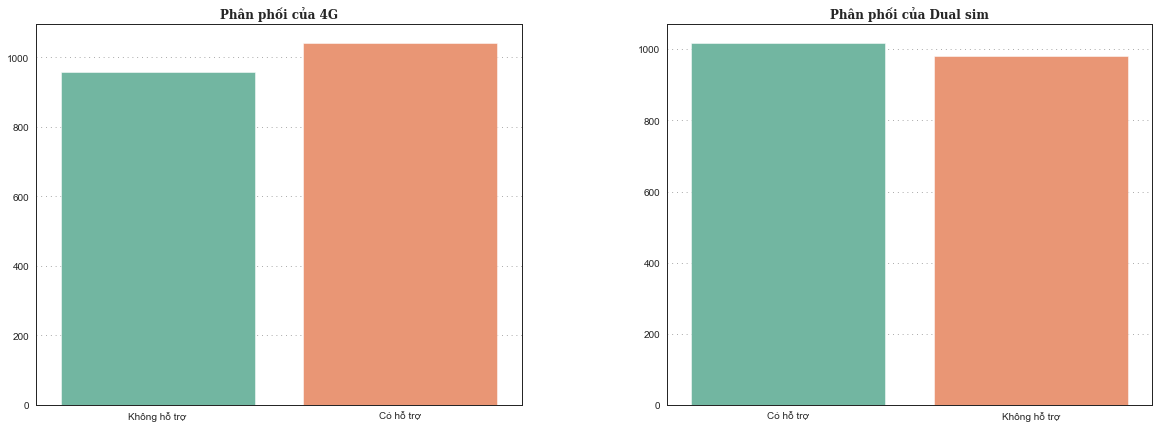

In [ ]:
df['4G_mapped'] = df['four_g'].map(b_mapping) 
df['Dual_sim_mapped'] = df['dual_sim'].map(b_mapping) 
print("Phân phối của 4G: \n{}".format(df['4G_mapped'].value_counts()))
print("Phân phối của Dual sim: \n{}".format(df['Dual_sim_mapped'].value_counts()))

fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.3, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

sns.countplot(x='4G_mapped', data=df, palette="Set2", ax=ax0)
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax0.set_title('Phân phối của 4G', fontsize=12,fontfamily='serif',fontweight='bold')
ax0.set_xlabel("")
ax0.set_ylabel("")   

sns.countplot(x='Dual_sim_mapped', data=df, palette="Set2", ax=ax1)
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax1.set_title('Phân phối của Dual sim',fontsize=12,fontfamily='serif',fontweight='bold')
ax1.set_xlabel("")
ax1.set_ylabel("") 

plt.show()

**Weight of the Phone**

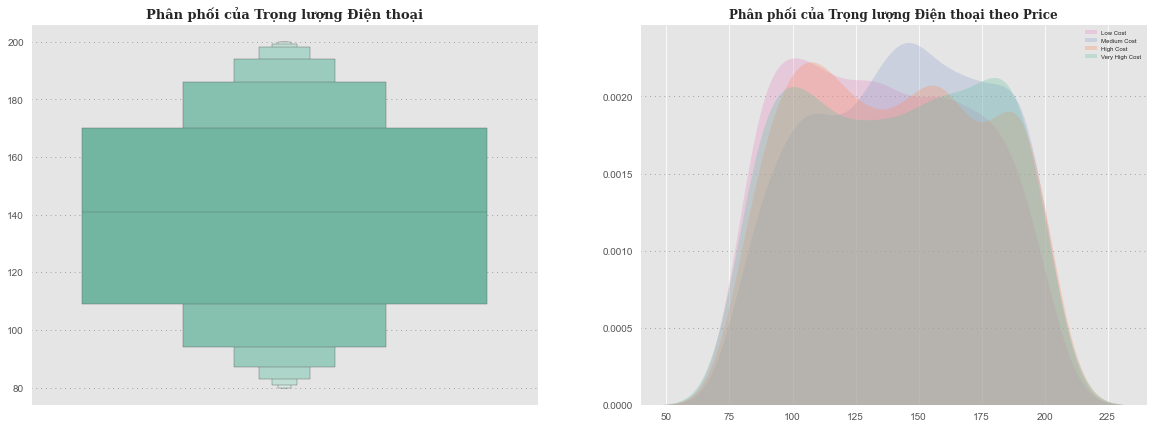

In [ ]:
fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(y='mobile_wt', data=df, ax=ax0, zorder=3, linewidth=0.4, palette="Set2")
ax0.set_xlabel("")
ax0.set_ylabel("")
ax0.set_title('Phân phối của Trọng lượng Điện thoại',fontsize=13,fontfamily='serif',fontweight='bold')

ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(x='mobile_wt', hue='price_range', shade=True, data=df, palette="Set2", ax=ax1, fill=True, alpha=.3, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title('Phân phối của Trọng lượng Điện thoại theo Price',fontsize=12,fontfamily='serif',fontweight='bold')
ax1.legend(['Low Cost ', 'Medium Cost','High Cost','Very High Cost'],fontsize=6,frameon=False)

plt.show()  

**Số lõi của bộ xử lý**

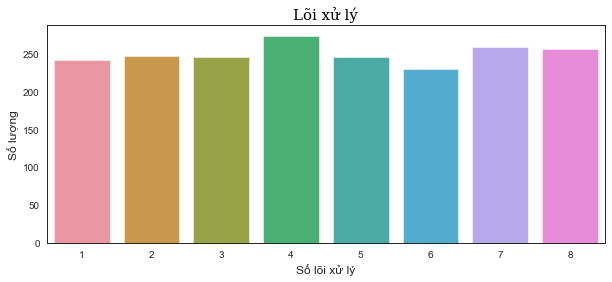

In [ ]:
sns.set_style('white')
counts = df['n_cores'].value_counts()

plt.figure(figsize=(10,4))
sns.barplot( x= counts.index, y= counts.values).set_title('Phân phối của lõi xử lý',fontsize=12,fontfamily='serif',fontweight='bold')

plt.ylabel('Số lượng')
plt.xlabel('Số lõi xử lý', style = 'normal')

plt.title('Lõi xử lý',color = 'black',fontsize=15)
plt.show()

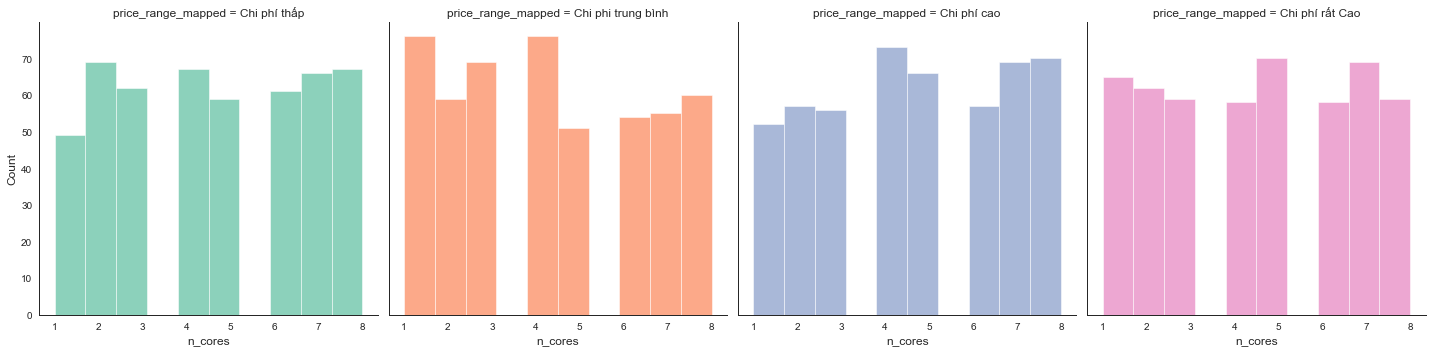

In [ ]:
grid = sns.FacetGrid(df, col="price_range_mapped", hue="price_range_mapped", palette="Set2", height=5)
grid.map(sns.histplot, "n_cores")
plt.show()

***
### 4. Tiền xử lý dữ liệu

### Dữ liệu Xây dựng mô hình

**Thư viện VectorAssembler**
Thư viện giúp biến đổi nhiều cột trở thành một cột duy nhất, có 2 tham số:

- `inputCols` - danh sách các tính năng để kết hợp thành một cột vector duy nhất
- `outputCol` - cột mới sẽ chứa vector đã biến đổi

In [ ]:
from pyspark.ml.feature import VectorAssembler
numericCols = ['battery_power','blue','clock_speed','dual_sim','fc','four_g','int_memory','m_dep','mobile_wt','n_cores','pc','px_height','px_width','ram','sc_h','sc_w',
                'talk_time','three_g','touch_screen','wifi']
assembler = VectorAssembler(inputCols= numericCols, outputCol = "features_vector")
output = assembler.transform(train_df)

**Thư viện StringIndexer** Thư viện giúp cột đầu vào là số, thư viện sẽ xâu chuỗi và lập chỉ mục các giá trị chuỗi.

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol = 'price_range', outputCol = 'label')
outputFixed = indexer.fit(output).transform(output)

**Thư viện StandardScaler** Thư viện giúp Tiêu chuẩn hóa dữ liệu

In [ ]:
# Dữ liệu huấn luyện mô hình
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol = "features_vector", outputCol = "features")
scalerl = scaler.fit(outputFixed).transform(outputFixed)

In [ ]:
df_final = scalerl.select('features','label')
df_final.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.44678889710945...|  0.0|
|[1.91617003652311...|  1.0|
|[2.32352684951317...|  2.0|
|[4.14411595784867...|  3.0|
|[1.28123958499110...|  2.0|
|[1.39957787703291...|  2.0|
|[4.14411595784867...|  1.0|
|[4.23059394049461...|  1.0|
|[3.28843907693099...|  0.0|
|[1.15834982017846...|  0.0|
|[1.75004128038749...|  3.0|
|[3.45911930583744...|  3.0|
|[4.13046153953616...|  1.0|
|[1.82741631749175...|  2.0|
|[4.24652409519254...|  0.0|
|[1.76369569870001...|  0.0|
|[1.90706709098143...|  3.0|
|[1.35406314932452...|  3.0|
|[2.57385785190930...|  1.0|
|[1.55205221485601...|  1.0|
+--------------------+-----+
only showing top 20 rows



**Hàm RandomSplit** 

Chia ngẫu nhiên dữ liệu thành 2 phần:
- Huấn luyện mô hình "<font color=green>train</font>".  
- Thử nghiệm mô hình "<font color=green>test</font>".

In [ ]:
train, test = df_final.randomSplit([0.75, 0.25], seed = 200)
print("Dữ liệu Huấn luyện - Train: {}\nDữ liệu Thử nghiệm - Test : {}".format(train.count(), test.count()))

Dữ liệu Huấn luyện - Train: 1510
Dữ liệu Thử nghiệm - Test : 490


### Dữ liệu bài toán cần giải quyết

In [ ]:
numericCols_test = ['battery_power','blue','clock_speed','dual_sim','fc','four_g','int_memory','m_dep','mobile_wt','n_cores','pc','px_height','px_width','ram','sc_h','sc_w',
'talk_time','three_g','touch_screen','wifi']
assembler_test = VectorAssembler(inputCols= numericCols_test, outputCol = "features_vector")
output_test = assembler_test.transform(test_df)

In [ ]:
output_test.show(3)

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+--------------------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|     features_vector|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+--------------------+
|         1043|   1|        1.8|       1| 14|     0|         5|  0.1|      193|      3| 16|      226|    1412|3476|  12|   7|        2|      0|           1|   0|[1043.0,1.0,1.8,1...|
|          841|   1|        0.5|       1|  4|     1|        61|  0.8|      191|      5| 12|      746|     857|3895|   6|   0|        7|      1|           0|   0|[841.0,1.0,0.5,1....|
|         1807|   1|        2.8|       0|  1|     0|        27|  0.9|      186|      

In [ ]:
scaler_test = StandardScaler(inputCol = "features_vector", outputCol = "features")
scalerl_test = scaler_test.fit(output_test).transform(output_test)

In [ ]:
df_final_test = scalerl_test.select("features")
df_final_test.show()

+--------------------+
|            features|
+--------------------+
|[2.41179363718882...|
|[1.94469649940153...|
|[4.17843825733480...|
|[3.57491175752053...|
|[3.31592720587609...|
|[3.38529806792371...|
|[3.97263803326020...|
|[1.92619760285550...|
|[2.56903425783008...|
|[3.51479034374593...|
|[3.46854310238085...|
|[3.10550225766499...|
|[2.08112586142851...|
|[2.75171086122214...|
|[1.45678810299995...|
|[4.26862037799670...|
|[4.590038705484,0...|
|[2.40948127512056...|
|[2.84651770602055...|
|[3.44079475756180...|
+--------------------+
only showing top 20 rows



***
### 5. Xây dựng Mô hình Phân loại
`pyspark.ml.classification` - Hỗ trợ xây dựng các mô hình phân loại.

`MulticlassClassificationEvaluator` - Giúp đánh giá mô hình phân loại nhiều lớp

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

**5.1. Thuật toán Naive Bayes**

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol = 'label', featuresCol = 'features', smoothing=1.0, modelType="gaussian")
nbm = nb.fit(train)
predictions_nb = nbm.transform(test)
predictions_nb.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(20,[0,2,6,7,8,9,...|  3.0|[-42.887705199154...|[1.30576858790117...|       3.0|
|(20,[0,2,6,7,8,9,...|  3.0|[-47.326341693423...|[1.95515098090978...|       3.0|
|[1.14241966548052...|  2.0|[-24.818483607582...|[3.08795216199826...|       2.0|
|[1.15379834740762...|  1.0|[-11.432031004922...|[0.04885690130402...|       1.0|
|[1.15607408379304...|  1.0|[-15.899629304253...|[0.00169766943380...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



- `Accuracy NaiveBayes`: Cho mô hình dự đoán chính xác 79.5%
- `Test Error NaiveBayes`: Cho thấy mô hình dự đoán sai 20.5% 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy_NaiveBayes = evaluator.evaluate(predictions_nb)
print("Accuracy NaiveBayes: {}".format(accuracy_NaiveBayes))
print("Test Error NaiveBayes: {}".format(1.0 - accuracy_NaiveBayes))

Accuracy NaiveBayes: 0.7950709164737121
Test Error NaiveBayes: 0.20492908352628791


**5.2. Thuật toán Decision Tree**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features', impurity="gini")
dtm = dt.fit(train)
predictions_dt = dtm.transform(test)
predictions_dt.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(20,[0,2,6,7,8,9,...|  3.0| [0.0,0.0,16.0,80.0]|[0.0,0.0,0.166666...|       3.0|
|(20,[0,2,6,7,8,9,...|  3.0| [0.0,0.0,8.0,213.0]|[0.0,0.0,0.036199...|       3.0|
|[1.14241966548052...|  2.0| [0.0,11.0,94.0,3.0]|[0.0,0.1018518518...|       2.0|
|[1.15379834740762...|  1.0|[15.0,166.0,28.0,...|[0.07177033492822...|       1.0|
|[1.15607408379304...|  1.0|[15.0,166.0,28.0,...|[0.07177033492822...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



- `Accuracy Decision Tree:` Cho mô hình dự đoán chính xác 82.5%
- `Test Error Decision Tree:` Cho thấy mô hình dự đoán sai 17.4% 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy_DecisionTree = evaluator.evaluate(predictions_dt)
print("Accuracy Decision Tree: {}".format(accuracy_DecisionTree))
print("Test Error Decision Tree: {}".format(1.0 - accuracy_DecisionTree))

Accuracy Decision Tree: 0.8254657133770305
Test Error Decision Tree: 0.17453428662296955


**5.3. Thuật toán Random Forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfm = rf.fit(train)
predictions = rfm.transform(test)
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(20,[0,2,6,7,8,9,...|  3.0|[1.82978132264283...|[0.09148906613214...|       3.0|
|(20,[0,2,6,7,8,9,...|  3.0|[0.21494642163122...|[0.01074732108156...|       3.0|
|[1.14241966548052...|  2.0|[1.24719540728534...|[0.06235977036426...|       2.0|
|[1.15379834740762...|  1.0|[5.31618886493685...|[0.26580944324684...|       1.0|
|[1.15607408379304...|  1.0|[5.93882716144437...|[0.29694135807221...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



- `Accuracy Random Forest`: Cho mô hình dự đoán chính xác 81.2%
- `Test Error Random Forest`: Cho thấy mô hình dự đoán sai 18.7% 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy_RandomForest = evaluator.evaluate(predictions)
print("Accuracy Random Forest: {}".format(accuracy_RandomForest))
print("Test Error Random Forest: {}".format(1.0 - accuracy_RandomForest))

Accuracy Random Forest: 0.8026862317515009
Test Error Random Forest: 0.1973137682484991


**5.4. Thuật toán Hồi quy Logistic**

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = 'label', featuresCol = 'features', maxIter=100)
lrm = lr.fit(train)
predictions_lr = lrm.transform(test)
predictions_lr.show(5)

+--------------------+-----+--------------------+-----------------+----------+
|            features|label|       rawPrediction|      probability|prediction|
+--------------------+-----+--------------------+-----------------+----------+
|(20,[0,2,6,7,8,9,...|  3.0|[-79705.829072017...|[0.0,0.0,0.0,1.0]|       3.0|
|(20,[0,2,6,7,8,9,...|  3.0|[-89292.495870477...|[0.0,0.0,0.0,1.0]|       3.0|
|[1.14241966548052...|  2.0|[-13116.570889635...|[0.0,0.0,1.0,0.0]|       2.0|
|[1.15379834740762...|  1.0|[12936.7976863840...|[0.0,1.0,0.0,0.0]|       1.0|
|[1.15607408379304...|  1.0|[5809.77464705384...|[0.0,1.0,0.0,0.0]|       1.0|
+--------------------+-----+--------------------+-----------------+----------+
only showing top 5 rows



- `Accuracy Logistic Regression`: Cho mô hình dự đoán chính xác 96.3%
- `Test Error Logistic Regression`: Cho thấy mô hình dự đoán sai 3.6% 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy_LogisticRegression = evaluator.evaluate(predictions_lr)
print(f"Accuracy LogisticRegression: {accuracy_LogisticRegression}")
print(f"Test Error LogisticRegression: {1.0 - accuracy_LogisticRegression}")

Accuracy LogisticRegression: 0.9634216889156099
Test Error LogisticRegression: 0.036578311084390136


**5.5. Thuật toán Multilayer Perceptron**

In [ ]:
layers = [len(assembler.getInputCols()),21,4,21,4,21,4]

print(layers)
from pyspark.ml.classification import MultilayerPerceptronClassifier
mlp = MultilayerPerceptronClassifier(labelCol='label',featuresCol='features',maxIter=100,layers=layers,blockSize=128,seed=100)
mlpm = mlp.fit(train)
predictions_mlp = mlpm.transform(test)
predictions_mlp.show(5)

[20, 21, 4, 21, 4, 21, 4]
+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(20,[0,2,6,7,8,9,...|  3.0|[-43.881525732814...|[6.49565099924482...|       3.0|
|(20,[0,2,6,7,8,9,...|  3.0|[-43.318814267547...|[2.40778836899723...|       3.0|
|[1.14241966548052...|  2.0|[-20.060791598481...|[1.14418839264541...|       2.0|
|[1.15379834740762...|  1.0|[6.99838578943130...|[7.42046228796929...|       1.0|
|[1.15607408379304...|  1.0|[1.72202549140971...|[8.86578257577961...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



- `Accuracy Multilayer Perceptron`: Cho mô hình dự đoán chính xác 97.5%
- `Test Error Multilayer Perceptron`: Cho thấy mô hình dự đoán sai 2.5% 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy_mpl = evaluator.evaluate(predictions_mlp)
print("Accuracy MulticlassClassification: {}".format(accuracy_mpl))
print("Test Error MulticlassClassification: {}".format(1.0 - accuracy_mpl))

Accuracy MulticlassClassification: 0.9754771140372531
Test Error MulticlassClassification: 0.024522885962746876


*** 
### 6. Kết luận và giải quyết bài toán

In [ ]:
model = spark.createDataFrame([("Naive Bayes", accuracy_NaiveBayes*100),
        ("Random forest", accuracy_RandomForest*100),
        ("Decision Tree", accuracy_DecisionTree*100),
        ("Logistic regression", accuracy_LogisticRegression*100),
        ("Multilayer perceptron", accuracy_mpl*100)], ["Thuật toán","Độ chính xác"])
model.toPandas()

,Thuật toán,Độ chính xác
0,Naive Bayes,79.507092
1,Random forest,80.268623
2,Decision Tree,82.546571
3,Logistic regression,96.342169
4,Multilayer perceptron,97.547711


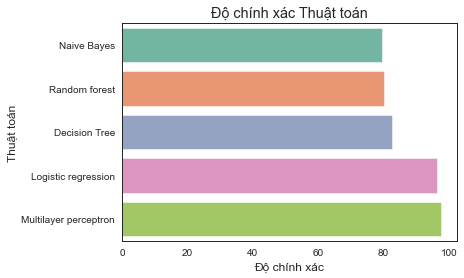

In [ ]:
model = model.toPandas()
sns.barplot(y = "Thuật toán", x = "Độ chính xác", data = model, palette="Set2").set(title='Độ chính xác Thuật toán')
plt.show()

### **Kết luận**

Từ việc sử dụng các thuật toán để xây dựng mô hình phân loại có thể thấy được Thuật toán *Multilayer perceptron* có độ chính xác cao nhất với <font color=green>97.5%</font> xếp sau là thuật toán *Logistic regression*: <font color=green>96.3%</font>.

Cả 2 thuật toán đều cho ra *Độ chính xác* cao trên 95%: 
- Vì vậy có thể sử dụng cả 2 thuật toán *Multilayer perceptron* và *Logistic regression* để giải quyết bài toán. 

- Nhưng thuật toán *Multilayer perceptron* có độ chính xác cao hơn nên sẽ sử dụng Thuật toán *Multilayer perceptron* để giải quyết bài toán.

***
### **Giải quyết bài toán**

**Sử dụng thuật toán Multilayer perceptron**

In [ ]:
layers = [len(assembler.getInputCols()),21,4,21,4,21,4]
print(layers)
from pyspark.ml.classification import MultilayerPerceptronClassifier
mlp = MultilayerPerceptronClassifier(labelCol='label',featuresCol='features',maxIter=100, layers=layers, blockSize=128, seed=100)
mlp = mlp.fit(train)
predictions_test = mlp.transform(df_final_test)
predictions_test.show()

[20, 21, 4, 21, 4, 21, 4]
+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[2.41179363718882...|[-39.652585112223...|[8.68858192256925...|       3.0|
|[1.94469649940153...|[-41.710653553935...|[9.68094152776379...|       3.0|
|[4.17843825733480...|[-37.605799780245...|[3.30494070897380...|       2.0|
|[3.57491175752053...|[-43.313643064845...|[2.43687743971283...|       3.0|
|[3.31592720587609...|[-1.1168057249163...|[9.50496178310419...|       1.0|
|[3.38529806792371...|[-41.557613996415...|[1.36883533255699...|       3.0|
|[3.97263803326020...|[-43.470485519655...|[1.69264242372040...|       3.0|
|[1.92619760285550...|[0.91238824090396...|[4.63697125514260...|       1.0|
|[2.56903425783008...|[-40.563858682492...|[1.25173094611489...|       3.0|
|[3.51479034374593...|[24.9304013256596...|[0.99875905116866..

**Sử dụng thuật toán Logistic regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = 'label', featuresCol = 'features')
lrm = lr.fit(train)
predictions_lr_test = lrm.transform(df_final_test)
predictions_lr_test.show()

+--------------------+--------------------+-----------------+----------+
|            features|       rawPrediction|      probability|prediction|
+--------------------+--------------------+-----------------+----------+
|[2.41179363718882...|[-51865.922096489...|[0.0,0.0,0.0,1.0]|       3.0|
|[1.94469649940153...|[-64707.934745711...|[0.0,0.0,0.0,1.0]|       3.0|
|[4.17843825733480...|[-44057.004161988...|[0.0,0.0,1.0,0.0]|       2.0|
|[3.57491175752053...|[-89987.349397196...|[0.0,0.0,0.0,1.0]|       3.0|
|[3.31592720587609...|[-3347.7802446154...|[0.0,1.0,0.0,0.0]|       1.0|
|[3.38529806792371...|[-61269.198740598...|[0.0,0.0,0.0,1.0]|       3.0|
|[3.97263803326020...|[-100477.39375710...|[0.0,0.0,0.0,1.0]|       3.0|
|[1.92619760285550...|[423.730738681551...|[0.0,1.0,0.0,0.0]|       1.0|
|[2.56903425783008...|[-55522.943421039...|[0.0,0.0,0.0,1.0]|       3.0|
|[3.51479034374593...|[47400.6928139994...|[1.0,0.0,0.0,0.0]|       0.0|
|[3.46854310238085...|[-87505.462503603...|[0.0,0.0

**Xuất file Excel cho kết quả vừa phân loại**

In [ ]:
predictions_lr_test.toPandas().to_excel('predictions2.xlsx')
predictions_test.toPandas().to_excel('predictions.xlsx')

In [ ]:
spark.stop() 